### import necessary packages

In [645]:
import datascience
import numpy as np
import pandas as pd
import re
from datascience import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import graphviz

/home/karen/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### data preprocessing

In [656]:
tagged = pd.read_csv(filepath_or_buffer='cleaned_tagged.csv', sep=',')

In [657]:
tagged = tagged.iloc[tagged['text'].drop_duplicates().index]

In [658]:
tagged = tagged.drop(tagged.columns[0], axis=1).reset_index(drop=True)

In [659]:
len(tagged)

503

In [660]:
tagged

,user_id,user_name,tweet_time,location,text,sentiment
0,2334231240,Debbi Matteucci,Tue Aug 28 19:56:09 +0000 2018,San Francisco CA,please dont loose the influence,negative
1,2593882602,Robert Nash,Tue Aug 28 19:56:10 +0000 2018,Maricopa AZ,agree he was deserving of a purple heart but n...,positive
2,999805424105803777,Dennis@millerd6,Tue Aug 28 19:56:10 +0000 2018,Ramona CA,it easy mccain didnt want there what would wan...,positive
3,759123137321693184,Crooked (Crypto) Pictures,Tue Aug 28 19:56:11 +0000 2018,None,shhh youll burst her bubble lol im sure sh,positive
4,43105114,Sandy {}{Q},Tue Aug 28 19:56:12 +0000 2018,Louisiana,it would say hes respecting mccains wisheshe t...,neutral
5,968025172438634496,Spydercat,Tue Aug 28 19:56:13 +0000 2018,Nancy Pelosi's Fabulous San Franshithole USA.,cat sometimes we get it right sometimes we don...,negative
6,2766239923,pierce d'art,Tue Aug 28 19:56:14 +0000 2018,out 'n about,cat 2008 johnmccain is mentally unfit to be pr...,negative
7,1022622446665588737,@nc0615 MAGA SUPER ELITE,Tue Aug 28 19:56:15 +0000 2018,Austin AR,jkopp i thought specifically did not want pres...,irrelevant
8,3098633816,Robert M. Goldstein - American,Tue Aug 28 19:56:15 +0000 2018,San Francisco,the best way to honor legacy and apparently hi...,positive
9,1218485030,Christopher Raiola,Tue Aug 28 19:56:15 +0000 2018,NJ USA,that hes not a phony like you ms brazile,irrelevant


limit_output extension: Maximum message size of 10000 exceeded with 15663 characters

In [661]:
nan_idx = tagged[list(map(lambda x: type(x) is np.float, list(tagged['text'])))].index

In [662]:
tagged = tagged.drop(tagged.index[nan_idx.values])

In [663]:
tagged = tagged.dropna(axis=0)

In [664]:
tagged.to_csv('debug.csv', sep=',')

In [665]:
classes = ['irrelevant', 'neutral', 'positive', 'negative']
for c in classes:
    print(c, len(tagged[tagged['sentiment']==c]))
    print('samples: ...\n')
    print(tagged['text'][tagged['sentiment']==c][:20])
    print('.....\n')

irrelevant 136
samples: ...

7     jkopp i thought specifically did not want pres...
9              that hes not a phony like you ms brazile
12                 mb u should water it once in a while
13    cry me a river of those crocodile tears your p...
29                 schwartz70 jkopp you can support som
36    i urge my fellow governors to lower flags in h...
42    kompromat lindsey what felony is it or just ne...
50                                    he served himself
55    in memory of the vietnam war hr299 for the sai...
59    cat what does it say about your american icon ...
61    so i have a story in december of 2003 my cousi...
63    was a tireless advocate for americas values an...
66    greer did you attend seth richs funeral or did...
68                                        reform gov an
70                       come on how do you expect to h
73                      will you be doing it in russian
74                 harbison and shes running for office
77    lindsey graha

### Model trials

#### CountVector+Tfidf-Transformer+DTree

In [666]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer

In [667]:
count_vect = CountVectorizer(max_df=0.95, min_df=2,
                            stop_words='english')
tfidf_vect = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')

tfidf = TfidfTransformer()
clf = DecisionTreeClassifier(criterion = 'entropy', random_state = 100,
                               max_depth=30, min_samples_leaf=2)

In [668]:
text_clf = Pipeline([('vect', count_vect),
                      ('tfidf', tfidf),
                      ('clf', clf),])
X_train, X_test, y_train, y_test = train_test_split(tagged['text'], tagged['sentiment'], test_size = 0.3, random_state = 100)
text_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
       ...       min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'))])

In [669]:
y_pred = text_clf.predict(X_test)

In [670]:
accuracy_score(y_test, y_pred)

0.42

In [671]:
dot_data= tree.export_graphviz(clf, out_file=None, feature_names=count_vect.get_feature_names())
graph = graphviz.Source(dot_data)
graph.render('tweet_tree')

'tweet_tree.pdf'

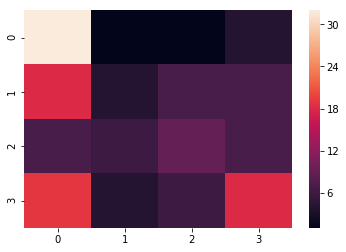

In [672]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm)

#### TfidfVector+DTree

In [673]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')

text_clf2 = Pipeline([
    ('tfidf', tfidf),
    ('clf', clf)
])
text_clf2.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='latin-1', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,...       min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'))])

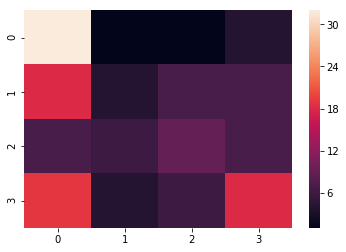

In [674]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm)

In [675]:
dot_data= tree.export_graphviz(clf, out_file=None, feature_names=tfidf.get_feature_names())
graph = graphviz.Source(dot_data)

In [676]:
text_clf2

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='latin-1', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,...       min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'))])

In [677]:
graph.render(filename='tweet_tree2')

'tweet_tree2.pdf'

In [613]:
y_pred = text_clf2.predict(X_test)

In [614]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.39869281045751637

#### Tf-Hub+nnlm-128

In [678]:
train_df = tagged[['text', 'sentiment']]
train_df

,text,sentiment
0,please dont loose the influence,negative
1,agree he was deserving of a purple heart but n...,positive
2,it easy mccain didnt want there what would wan...,positive
3,shhh youll burst her bubble lol im sure sh,positive
4,it would say hes respecting mccains wisheshe t...,neutral
5,cat sometimes we get it right sometimes we don...,negative
6,cat 2008 johnmccain is mentally unfit to be pr...,negative
7,jkopp i thought specifically did not want pres...,irrelevant
8,the best way to honor legacy and apparently hi...,positive
9,that hes not a phony like you ms brazile,irrelevant


In [ ]:
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], num_epochs=None, shuffle=True)

predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], shuffle=False)

predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df, test_df["polarity"], shuffle=False)

train_input_fn

In [ ]:
def train_and_evaluate_with_module(hub_module, train_module=False):
  embedded_text_feature_column = hub.text_embedding_column(
      key="sentence", module_spec=hub_module, trainable=train_module)

  estimator = tf.estimator.DNNClassifier(
      hidden_units=[500, 100],
      feature_columns=[embedded_text_feature_column],
      n_classes=4,
      optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

  estimator.train(input_fn=train_input_fn, steps=1000)

  train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
  test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

  training_set_accuracy = train_eval_result["accuracy"]
  test_set_accuracy = test_eval_result["accuracy"]

  return {
      "Training accuracy": training_set_accuracy,
      "Test accuracy": test_set_accuracy
  }


results = {}
results["nnlm-en-dim128"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/nnlm-en-dim128/1")
results["nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/nnlm-en-dim128/1", True)
results["random-nnlm-en-dim128"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/random-nnlm-en-dim128/1")
results["random-nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/random-nnlm-en-dim128/1", True)